a.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# a few auxiliary plotting functions for the MNIST dataset below
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    

# MNIST

In [3]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original') # Depreciated in newer versions of sklearn

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [5]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int) # in mnist_784 data type is string-casted ints
X.shape, y.shape, 28*28

((70000, 784), (70000,), 784)

### Let's split train-test data and shuffle the training data

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Lets make our data binary-label
since this is a multi-label data, let's make it into binary data, by classifying if a digit is i or not in an array

In [7]:
y_trains = [0]*10
y_tests = [0]*10

for i in range(10):
    y_trains[i] = (y_train == i)
    y_tests[i]  = (y_test == i)

In [10]:
y_tests[5].sum()

892

In [11]:
from sklearn.linear_model import SGDClassifier

logit_clfs = [0]*10

for i in range(10):
    #this loss corresponds to logistic regression
    logit_clfs[i] = SGDClassifier(
        random_state=42, loss='log', max_iter=5, tol=-np.infty) 
    logit_clfs[i].fit(X_train, y_trains[i])


### Now let's do the same thing for Hinge loss

In [13]:
hinge_clfs = [0]*10

for i in range(10):
    #this loss corresponds to SVM
    hinge_clfs[i] = SGDClassifier(random_state=42, loss='hinge', max_iter=5, tol=-np.infty) 
    hinge_clfs[i].fit(X_train, y_trains[i])

### Confusion Matrix
Let's look at the Confusion Matrix which counts how many times class A was predicted as class B. For the two class problem, it is defined as:

$$
C  =
\begin{bmatrix}
    N_{A,A} & N_{A,B} \\
    N_{B,A} & N_{B,B} \\
\end{bmatrix}
=
\begin{bmatrix}
    N_{actual=A,predict=A} & N_{actual=A,predict=B} \\
    N_{actual=B,predict=A} & N_{actual=B,predict=B} \\
\end{bmatrix} 
$$

Using the cross_val_predict method in sklearn we can split the train data in to 3 subsets and for each subset, we use the rest of the train data to predict it. This way we end up with predictions y_train_pred for each training sample, from which we can compute the confusion matrix


In [19]:
models = [0]*10
for i in range(10):
    models[i] = [logit_clfs[i],hinge_clfs[i]]

Getting all of the confusion matrices:

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

confusion_matrices = []

dict_y_tpred={}
for i in range(10):
    for model in models[i]:
        y_train_pred = cross_val_predict(model, X_train, y_trains[i], cv=3)
        dict_y_tpred[model.__class__] = y_train_pred
        print(model.__class__)
        print(confusion_matrix(y_trains[i], y_train_pred))
        print('')
        confusion_matrices.append(confusion_matrix(y_trains[i], y_train_pred))

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[53661   416]
 [  303  5620]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[53415   662]
 [  382  5541]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[53000   258]
 [  383  6359]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[52998   260]
 [  361  6381]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[52321  1721]
 [  608  5350]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[51275  2767]
 [  711  5247]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[52285  1584]
 [ 1259  4872]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[50587  3282]
 [ 1246  4885]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[53670   488]
 [  931  4911]]

<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
[[53353   805]
 [  664  5178]]

<class 'sklearn.linear_model.s

Now let's get all of the F1 scores:

In [30]:
# F1 scoring function
def F1_score(A):
    return A[1][1]/(A[1][1]+(0.5*(A[0][1]+A[1][0])))

In [31]:
log_f1_scores = []
hinge_f1_scores = []

for i in [0,2,4,6,8,10,12,14,16,18]:
    log_f1_scores.append(F1_score(confusion_matrices[i]))
    hinge_f1_scores.append(F1_score(confusion_matrices[i+1]))

In [40]:
print("       i      Logistic F1 Score   Hinge F1 Score")

for i in range(10):
    n = i
    log_score = log_f1_scores[i]
    hinge_score = hinge_f1_scores[i]
    
    #      character string with formatting information
    table_line = "{n:8.0f}     {log_score:8.5f}            {hinge_score:8.5f}"
    #      put the numbers into the formatted string 
    table_line = table_line.format(n = n, log_score = log_score, hinge_score = hinge_score)
    #      print the line of the table, character string with formatted numbers embedded
    print(table_line)

       i      Logistic F1 Score   Hinge F1 Score
       0      0.93988             0.91390
       1      0.95202             0.95360
       2      0.82124             0.75107
       3      0.77413             0.68331
       4      0.87377             0.87577
       5      0.77018             0.77347
       6      0.88907             0.83238
       7      0.90228             0.90304
       8      0.58540             0.54549
       9      0.73572             0.72636


The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers. Suppose that classifier A has a higher recall, and classifier B has higher precision. In this case, the F1-scores for both the classifiers can be used to determine which one produces better results.

As we can see from the table above, for i = 0,2,3,6,8,9, the Logistic SGD Regression binary classifiers perform (quite marginally) better than their Hinge Loss SGD binary classifier counterparts.

b.

#### Let's get the scores for all our predictions using the cross_val_predict method

In [41]:
y_scores_logit = [0]*10
y_scores_hinge = [0]*10

for i in range(10):
    y_scores_logit[i] = cross_val_predict(logit_clfs[i], X_train, y_trains[i], cv=3,
                                          method="decision_function")
    y_scores_hinge[i] = cross_val_predict(hinge_clfs[i], X_train, y_trains[i], cv=3,
                                          method="decision_function")

In [46]:
for i in range(10):
    # hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
    if y_scores_logit[i].ndim == 2:
        y_scores_logit[i] = y_scores_logit[i][:, 1]
    if y_scores_hinge[i].ndim == 2:
        y_scores_hinge[i] = y_scores_hinge[i][:, 1]

#### SKlearn has a percision_recall_curve method which varies the threshold and for each threshold value it computes the precision and recall scores

In [62]:
from sklearn.metrics import precision_recall_curve

precisions_list1 = [0]*10
recalls_list1 = [0]*10
thresholds_list1 = [0]*10

precisions_list2 = [0]*10
recalls_list2 = [0]*10
thresholds_list2 = [0]*10

for i in range(10):
    precisions_list1[i], recalls_list1[i], thresholds_list1[i] = precision_recall_curve(y_trains[i], y_scores_logit[i])
    precisions_list2[i], recalls_list2[i], thresholds_list2[i] = precision_recall_curve(y_trains[i], y_scores_hinge[i])

In [74]:
# P-R plot function from notes
def plot_precision_vs_recall(precisions, recalls, lab, color='b-'):
    plt.plot(recalls, precisions, color, linewidth=2,label=lab)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

In [65]:
#this is the Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb_clfs = [0]*10
y_scores_nb = [0]*10
precisions_nb = [0]*10
recalls_nb = [0]*10
thresholds_nb = [0]*10

for i in range(10):
    gnb_clfs[i] = GaussianNB()
    gnb_clfs[i].fit(X_train, y_trains[i])

    y_scores_nb[i] = cross_val_predict(gnb_clfs[i], X_train, y_trains[i], cv=3,
                                 method="predict_proba")[:, 1]


    precisions_nb[i], recalls_nb[i], thresholds_nb[i] = precision_recall_curve(
        y_trains[i], y_scores_nb[i])

Now let's plot all the P-R curves:

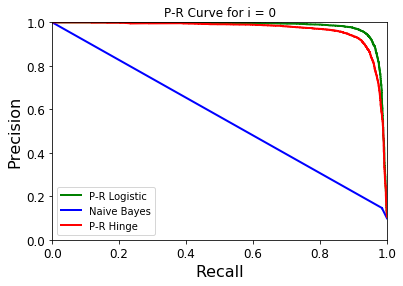

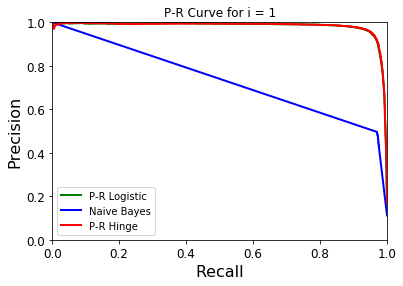

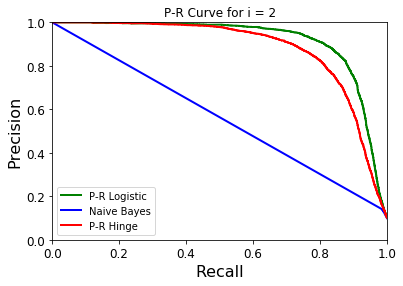

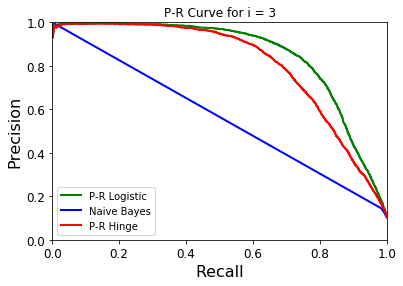

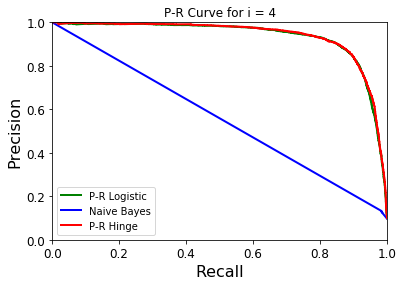

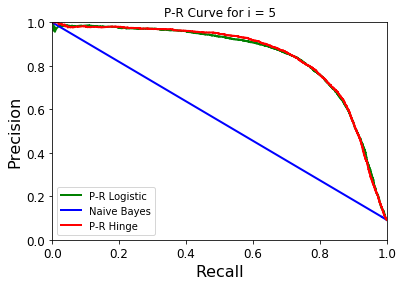

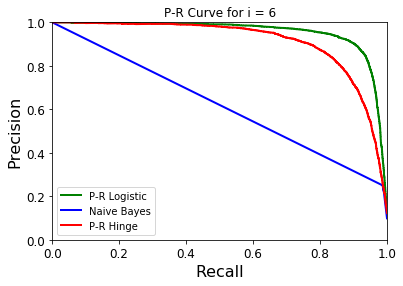

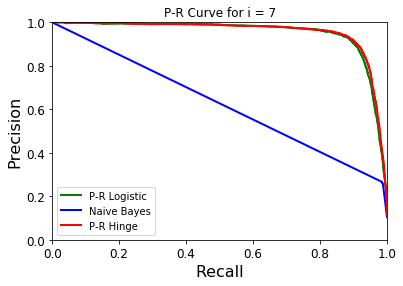

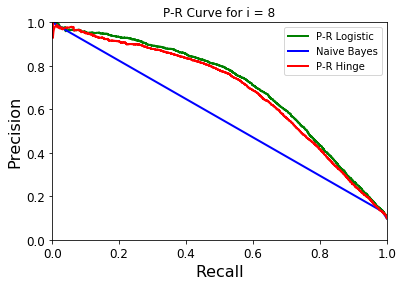

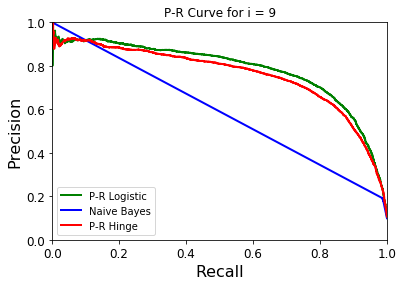

In [87]:
for i in range(10):

    plt.figure(figsize=(6, 4))
    plot_precision_vs_recall(precisions_list1[i], recalls_list1[i], 'P-R Logistic', color='g-')
    plot_precision_vs_recall(precisions_nb[i], recalls_nb[i], 'Naive Bayes')
    plot_precision_vs_recall(precisions_list2[i], recalls_list2[i], 'P-R Hinge', color='r-')
    plt.title(f'P-R Curve for i = {i}')
    plt.legend()


Our goal is to find models that have both high precision and high recall. Thus from the P-R curves:

Logistic SGD Regression binary classifiers perform better for i=0,2,3,6,8,9

Hinge Loss SGD binary classifiers perform marginally better for i=1,4,5,7 but performance is very similar for these.

#### Now let's do the same thing as above but for the ROC curves:

In [89]:
from sklearn.metrics import roc_curve

fpr1 = [0]*10
tpr1 = [0]*10
thresholds_roc1 = [0]*10
fpr2 = [0]*10
tpr2 = [0]*10
thresholds_roc2 = [0]*10
fpr_nb = [0]*10
tpr_nb = [0]*10
thresholds_nb = [0]*10

for i in range(10):
    fpr1[i], tpr1[i], thresholds_roc1[i] = roc_curve(y_trains[i], y_scores_logit[i])
    fpr2[i], tpr2[i], thresholds_roc2[i] = roc_curve(y_trains[i], y_scores_hinge[i])
    fpr_nb[i], tpr_nb[i], thresholds_nb[i] = roc_curve(y_trains[i], y_scores_nb[i])

In [90]:
def plot_roc_curve(fpr, tpr, label=None, color='b-'):
    plt.plot(fpr, tpr, color, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

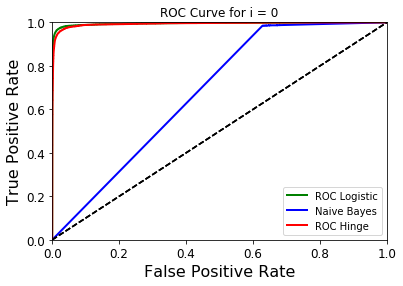

Area under the curve:
	SGD Logit AUC: 0.9947705523334232 
 	SGD Hinge AUC: 0.9930239885834342


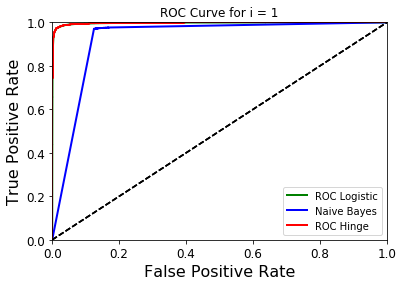

Area under the curve:
	SGD Logit AUC: 0.9970790978611487 
 	SGD Hinge AUC: 0.997157325942116


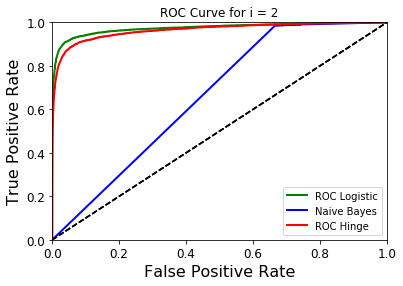

Area under the curve:
	SGD Logit AUC: 0.9735000566925686 
 	SGD Hinge AUC: 0.963701258351408


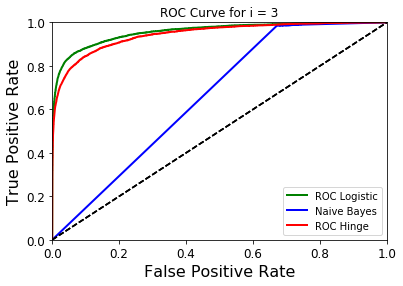

Area under the curve:
	SGD Logit AUC: 0.9568948320018045 
 	SGD Hinge AUC: 0.9441074844636828


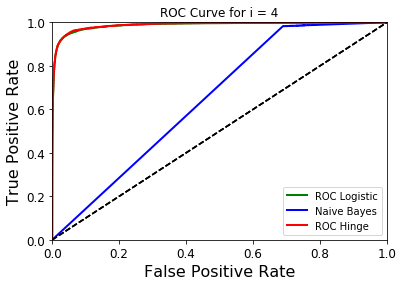

Area under the curve:
	SGD Logit AUC: 0.9868992653761528 
 	SGD Hinge AUC: 0.9875977428134216


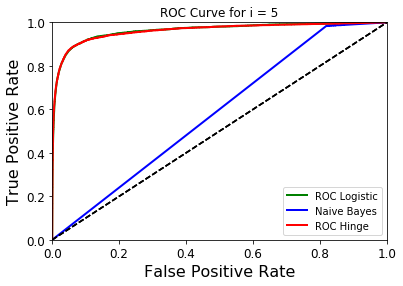

Area under the curve:
	SGD Logit AUC: 0.9621972261393621 
 	SGD Hinge AUC: 0.9614189997126434


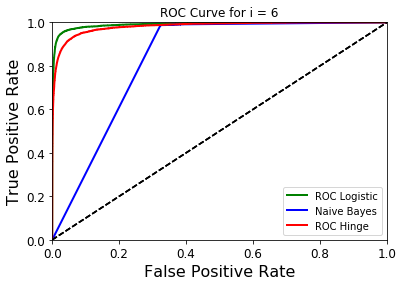

Area under the curve:
	SGD Logit AUC: 0.9906441683269217 
 	SGD Hinge AUC: 0.9813147569249451


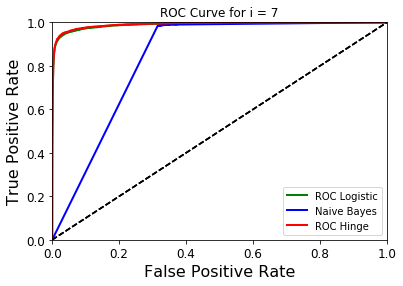

Area under the curve:
	SGD Logit AUC: 0.9895726085068673 
 	SGD Hinge AUC: 0.990628738724094


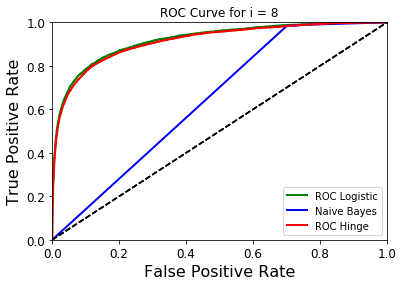

Area under the curve:
	SGD Logit AUC: 0.9190701228216582 
 	SGD Hinge AUC: 0.9131436041924098


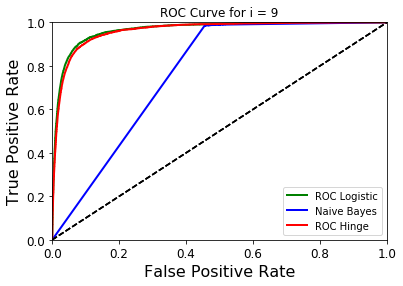

Area under the curve:
	SGD Logit AUC: 0.9651386286683745 
 	SGD Hinge AUC: 0.961324558407898


In [93]:
from sklearn.metrics import roc_auc_score

for i in range(10):
    plt.figure(figsize=(6, 4))
    plot_roc_curve(fpr1[i], tpr1[i], 'ROC Logistic', color='g-')
    plot_roc_curve(fpr_nb[i], tpr_nb[i], 'Naive Bayes')
    plot_roc_curve(fpr2[i], tpr2[i], 'ROC Hinge', color='r-')
    plt.title(f'ROC Curve for i = {i}')
    plt.legend()
    plt.show()
    
    print('Area under the curve:')
    print(
        '\tSGD Logit AUC:', roc_auc_score(y_trains[i], y_scores_logit[i]), '\n',
        '\tSGD Hinge AUC:', roc_auc_score(y_trains[i], y_scores_hinge[i]))

Our goal is to find models that have a low FPR and high TPR. Thus from the ROC curves and the auc function:

Logistic SGD Regression binary classifiers perform better for i=0,2,3,5*,6,8,9

Hinge Loss SGD binary classifiers perform marginally better for i=1,4,7 but performance is very similar for these.

*Note i=5 is extremely marginal

Thus we can conclude that there exists a pattern between when classifiers perform well in the P-R curve and the ROC curve as the logistic classifiers perform best for the same i's (same for the hinge loss).

#### Explanation: 
Note that a point in the ROC space defines a unique confusion matrix here. Also in the P-R space, with a fixed number of positive and negative examples, given the other three entries in a matrix, TN is uniquely determined.

Therefore we have a one-to-one mapping between confusion matrices and points in PR space. This implies that we also have a one-to-one mapping between points in the ROC space and the P-R space; hence, so we can translate a curve in ROC space to PR space and vice-versa.